In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
BATCH_SIZE = 256

Загрузим датесет `MNIST` с помощьб `torchvision`. Будем использовать обычную *feedforward* нейронную сеть, поэтому все изображения будем рассматривать как 1D массивы.

In [3]:
def pil2vec(image):
    return ToTensor()(image).flatten()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = os.path.join(os.getcwd(), 'data')
mnist_train = MNIST(root=DATA_DIR, train=True, transform=pil2vec, download=True)
mnist_test = MNIST(root=DATA_DIR, train=False, transform=pil2vec, download=True)
train_dataloader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

Посмотрим на 9 изображений из тренировочного датасета.

In [4]:
def plot_9_digits(imgs, labels):
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
    fig.set_size_inches(7, 7)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i].reshape(28, 28), cmap=plt.cm.gray)
        ax.set_title(f'Label: {labels[i]}')
    return fig, axes

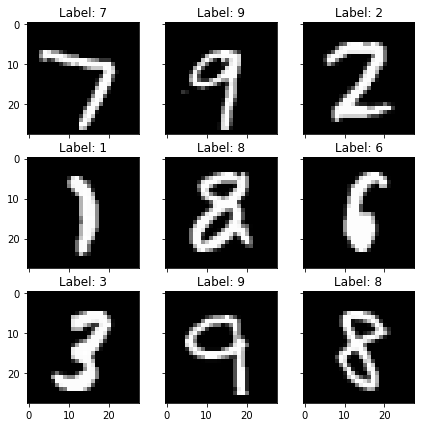

In [5]:
inds = np.random.choice(len(mnist_train), size=9)
imgs = [mnist_train[i][0] for i in inds]
labels = [mnist_train[i][1] for i in inds]

fig, _ = plot_9_digits(imgs, labels)

Далее обучим нейронную сеть классифицировать изображения.

In [6]:
def calculate_accuracy(output: np.ndarray, target: np.ndarray):
    predictions = np.argmax(output, axis=1)
    return np.sum(predictions == target) / len(target)

In [7]:
def train(model, dataloader, loss_function, optimizer, device, epochs):
    train_losses = np.zeros(epochs)
    train_accuracies = np.zeros_like(train_losses)
    model.train()
    for epoch in range(epochs):
        losses = np.zeros(len(dataloader))
        accuracies = np.zeros_like(losses)
        batch_sizes = np.zeros(len(dataloader), dtype='int')

        for i, [X, y] in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            output = model.forward(X)
            loss = loss_function(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i] = loss.cpu().detach().numpy().item()
            accuracies[i] = calculate_accuracy(output.detach().cpu().numpy(),
                                               y.detach().cpu().numpy())
            batch_sizes[i] = X.size(1)

        num_samples = np.sum(batch_sizes)
        train_losses[epoch] = sum(losses * batch_sizes) / num_samples
        train_accuracies[epoch] = sum(accuracies * batch_sizes) / num_samples
        print(f'\rEpoch: {epoch + 1:03d}, loss: {train_losses[epoch]:.3e}, accuracy: {train_accuracies[epoch]:.3e}', end='')

    print()
    return train_losses, train_accuracies

In [8]:
class MnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.stack(x)

Epoch: 010, loss: 3.882e-02, accuracy: 9.880e-01


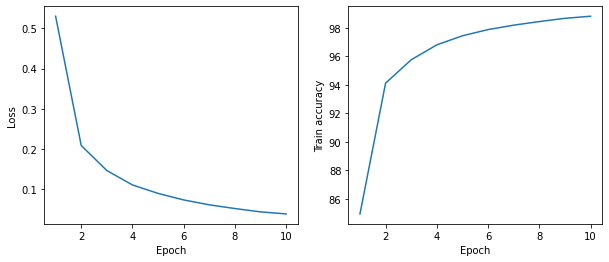

In [9]:
EPOCHS = 10
LEARNING_RATE = 1e-3

model = MnistClassifier().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
train_losses, train_accuracies = train(
    model, train_dataloader, loss_function, optimizer, device, EPOCHS)

plt.figure(figsize=(10, 4))
epochs = np.arange(1, EPOCHS + 1)
plt.subplot(121)
plt.plot(epochs, train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(epochs, train_accuracies * 100)
plt.xlabel('Epoch')
plt.ylabel('Train accuracy');

In [10]:
def evaluate(model, dataloader, device):
    predictions = []
    answers = []
    model.eval()

    with torch.no_grad():
        for i, [X, y] in enumerate(dataloader):
            X = X.to(device)
            output = model.forward(X)
            predictions.append(np.argmax(output.detach().cpu().numpy(), axis=1))
            answers.append(y.numpy())

    return np.concatenate(predictions), np.concatenate(answers)

Text(0.5, 1.0, 'Test accuracy: 98.0%')

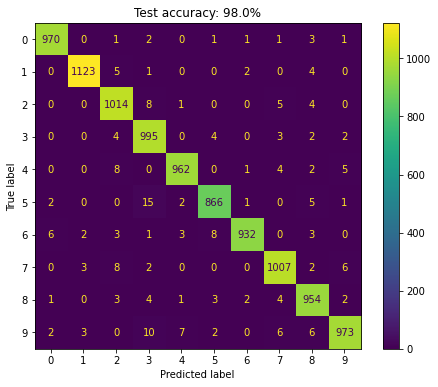

In [11]:
pred, ans = evaluate(model, test_dataloader, device)
test_accuracy = (pred == ans).sum() / len(ans)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ConfusionMatrixDisplay.from_predictions(ans, pred, ax=ax)
ax.set_title(f'Test accuracy: {test_accuracy * 100:.1f}%')

Видим, что модель показывает хорошие результаты как на тренировочном, так и на тестовом датасете.

Далее возьмём 9 правильно определённых обученной моделью изображений из тестового датасета.

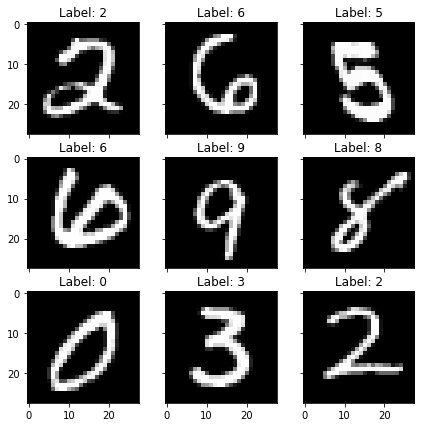

In [12]:
inds = np.random.choice(np.where(pred == ans)[0], size=9)
original_imgs = [mnist_test[i][0] for i in inds]
adv_dataloader = DataLoader([mnist_test[i] for i in inds], batch_size=9, shuffle=False)

labels, true_labels = evaluate(model, adv_dataloader, device)
assert (labels == true_labels).all()
fig = plot_9_digits(original_imgs, labels)

Теперь изменим эти изображения таким образом, чтобы модель определяла их всех как какое-то из чисел, не присутствующее в данной выборке.

In [13]:
ADV_TARGET = np.random.choice(list(set(range(10)).difference(labels)))
print(f'Target number is {ADV_TARGET}')

X = torch.stack(original_imgs).to(device)
X.requires_grad_(True)
optimizer = torch.optim.SGD(params=iter([X]), lr=2e-2)
loss_function = nn.CrossEntropyLoss()

for _ in range(100):
    output = model.forward(X)
    loss = loss_function(output, torch.tensor([ADV_TARGET]*9, device=device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Target number is 1


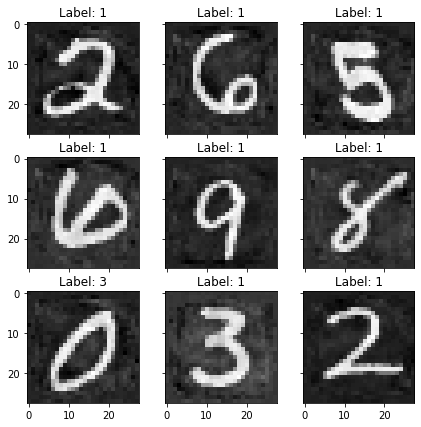

In [14]:
model.eval()
with torch.no_grad():
    output = model.forward(X)
    new_labels = np.argmax(output.detach().cpu().numpy(), axis=1)
new_imgs = list(X.detach().cpu().numpy())

fig, _ = plot_9_digits(new_imgs, new_labels)

Как видим, нам действительно удалось изменить изображения таким образом, чтобы модель классифицировала их как какое-то другое число.